In [1]:
%pip install statsmodels
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 132.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 53.1 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 141.4 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [71]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima import auto_arima
import numpy as np 
from sklearn.metrics import mean_absolute_error

In [74]:
class TimeSeriesAnalysis:
    def __init__(self, data):
        self.df = pd.read_csv(data)

    def get_time_series(self, target):
        self.target = target
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df.set_index('date', inplace=True)
        self.ts_df = self.df[target]

    def get_summary_stats(self):
        print(f"Mean {self.target}: ", self.ts_df.mean())
        print(f"Standard Dev. {self.target}: ", self.ts_df.std())

    def visualize(self, line_plot, histogram, decompose):
        sns.set()
        if line_plot:
            plt.plot(self.ts_df)
            plt.title(f"Daily {self.target}")
            plt.xticks(rotation=45)
            plt.show()
        if histogram:
            self.ts_df.hist(bins=100)
            plt.title(f"Histogram of {self.target}")
            plt.show()
        if decompose:
            decomposition = sm.tsa.seasonal_decompose(self.ts_df, model='additive', period =180)
            fig = decomposition.plot()
            plt.show()

    def stationarity_test(self):
            adft = adfuller(self.ts_df,autolag="AIC")
            kpsst = kpss(self.ts_df)

            adf_results = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used",
    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})

            kpss_results = pd.DataFrame({"Values":[kpsst[0],kpsst[1],kpsst[2], kpsst[3]['1%'], kpsst[3]['5%'], kpsst[3]['10%']] , "Metric":["Test Statistics","p-value","No. of lags used",
    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
            
            self.adf_results = adf_results
            self.kpss_results = kpss_results
            print(self.adf_results)
            print(self.kpss_results)
            self.adf_status = adf_results['Values'].iloc[1] > adf_results['Values'].iloc[4]
            self.kpss_status = kpss_results['Values'].iloc[1] < kpss_results['Values'].iloc[3]
            print("ADF Results: ", self.adf_status)
            print("KPSS Results: ", self.kpss_status)  
   
    def train_test_split(self):
        self.y_train = self.ts_df[self.ts_df.index <= pd.to_datetime('2016-07')]
   
    def fit(self):
        self.y_train.fillna(0,inplace=True)
        model = auto_arima(self.y_train, trace=True,  error_action='ignore', suppress_warnings=True, stationary=True)
        model.fit(self.y_train)
        forecast = model.predict(n_periods=len(self.ts_df))
        self.forecast = pd.DataFrame(forecast,index = self.ts_df.index,columns=['Prediction'])

        self.ts_df = pd.DataFrame(self.ts_df, index = self.forecast.index)

        self.y_train = self.ts_df[self.ts_df.index < pd.to_datetime('2016-07')]
        
        self.y_test = self.ts_df[self.ts_df.index > pd.to_datetime('2016-07')]
       
        self.forecast = self.forecast[self.forecast.index > pd.to_datetime('2016-07')]

    
    def validate(self):
        plt.plot(self.y_train, label='Train')
        plt.plot(self.y_test, label='Test')
        plt.plot(self.forecast, label='Prediction')
        mae = np.round(mean_absolute_error(self.y_test, self.forecast), 2)
        plt.title(f'{self.target} Prediction; MAE: {mae}')
        plt.xlabel('Date')
        plt.ylabel(f'{self.target}')
        plt.xticks(rotation=45)
        plt.legend(loc='upper left', fontsize=8)
        plt.show()

In [56]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate_df = climate.df
climate_df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('meantemp')
ts_df = climate.ts_df
ts_df.head()

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Name: meantemp, dtype: float64

In [6]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('meantemp')
climate.get_summary_stats()

Mean meantemp:  25.495520655761762
Standard Dev. meantemp:  7.348102725432476


In [7]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('humidity')
climate.get_summary_stats()

climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('wind_speed')
climate.get_summary_stats()

climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('meanpressure')
climate.get_summary_stats()

Mean humidity:  60.77170158004638
Standard Dev. humidity:  16.769652268485306
Mean wind_speed:  6.802208747447473
Standard Dev. wind_speed:  4.561602164272007
Mean meanpressure:  1011.1045475940377
Standard Dev. meanpressure:  180.2316683392096


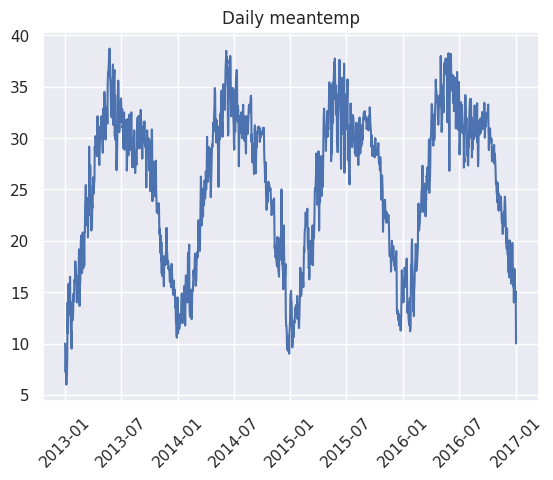

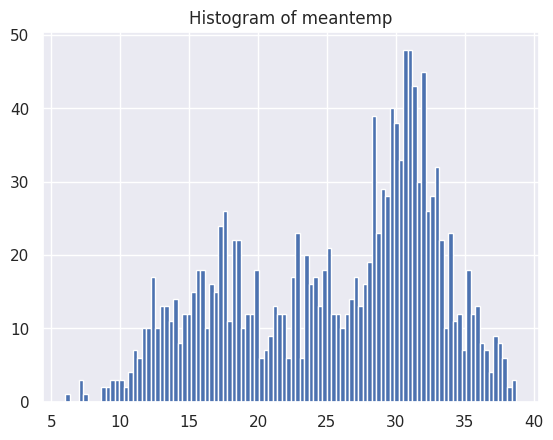

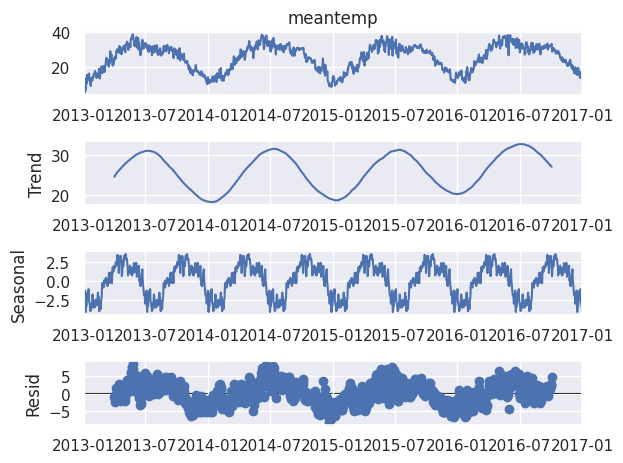

In [8]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('meantemp')
climate.visualize(line_plot = True, histogram = True, decompose = True)

In [9]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('meantemp')
climate.stationarity_test()
climate.adf_results

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,Values,Metric
0,-2.021069,Test Statistics
1,0.277412,p-value
2,10.000000,No. of lags used
3,1451.000000,Number of observations used
4,-3.434865,critical value (1%)
5,-2.863534,critical value (5%)
6,-2.567832,critical value (10%)


In [10]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('meantemp')
climate.stationarity_test()
climate.kpss_results

/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,Values,Metric
0,0.187864,Test Statistics
1,0.100000,p-value
2,25.000000,No. of lags used
3,0.739000,critical value (1%)
4,0.463000,critical value (5%)
5,0.347000,critical value (10%)


In [68]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('meantemp')
climate.stationarity_test()

        Values                       Metric
0    -2.021069              Test Statistics
1     0.277412                      p-value
2    10.000000             No. of lags used
3  1451.000000  Number of observations used
4    -3.434865          critical value (1%)
5    -2.863534          critical value (5%)
6    -2.567832         critical value (10%)
      Values                Metric
0   0.187864       Test Statistics
1   0.100000               p-value
2  25.000000      No. of lags used
3   0.739000   critical value (1%)
4   0.463000   critical value (5%)
5   0.347000  critical value (10%)
ADF Results:  True
KPSS Results:  True
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
        Values                       Metric
0    -2.021069              Test Statistics
1     0.277412                      p-value
2    10.000000             No. of lags used
3  1451.000000  Number of observations used
4    -3.434865          critical value (1%)
5    -2.863534          critical value (5%)
6    -2.567832         critical value (10%)
      Values                Metric
0   0.187864       Test Statistics
1   0.100000               p-value
2  25.000000      No. of lags used
3   0.739000   critical value (1%)
4   0.463000   critical value (5%)
5   0.347000  critical value (10%)
ADF Results:  True
KPSS Results:  True
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4889.074, Time=0.67 s

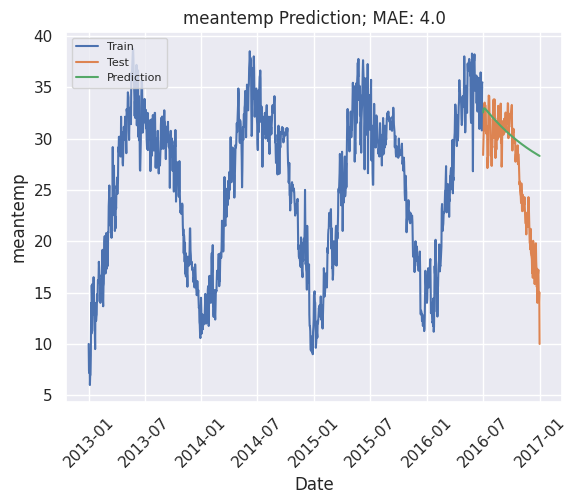

In [75]:
climate = TimeSeriesAnalysis('DailyDelhiClimate.csv')
climate.get_time_series('meantemp')
climate.stationarity_test()
climate.train_test_split()
climate.fit()
climate.validate()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4ba5f52-9d5f-4d6a-b7ff-a746eafe9852' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>